In [68]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import requests



In [69]:
def load_model():
    model = models.resnet18(pretrained=True)
    return model

In [70]:
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)

In [71]:
def load_class_labels():
    """Loads the ImageNet class labels from a remote URL."""
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
    try:
        response = requests.get(url)
        response.raise_for_status()  
        return response.json()
    except requests.exceptions.RequestException as e:
        raise RuntimeError(f"Failed to fetch ImageNet class labels: {e}")

In [72]:
def return_image(index, dir):
    image_files = [f for f in os.listdir(dir) if f.endswith(('png', 'jpg', 'JPEG'))]
    if index >= len(image_files):
        raise ValueError("Index out of range for the given directory.")
    image_path = os.path.join(dir, image_files[index])
    image = Image.open(image_path).convert("RGB")
    return image, image_path

In [73]:
def predict_class(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class_idx = torch.max(output, 1)
    return predicted_class_idx.item()


In [74]:
def visualize_images(original_image, adversarial_image, noise, original_label, adversarial_label):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    original_image_numpy = original_image.squeeze(0).detach().permute(1, 2, 0).cpu().numpy()
    adversarial_image_numpy = adversarial_image.squeeze(0).detach().permute(1, 2, 0).cpu().numpy()
    noise_numpy = noise.squeeze(0).detach().permute(1, 2, 0).cpu().numpy()

    original_image_numpy = std * original_image_numpy + mean
    adversarial_image_numpy = std * adversarial_image_numpy + mean
    noise_numpy = std * noise_numpy  

    original_image_numpy = np.clip(original_image_numpy, 0, 1)
    adversarial_image_numpy = np.clip(adversarial_image_numpy, 0, 1)
    noise_numpy = np.clip(noise_numpy, -1, 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image_numpy)
    plt.title(f"Original Image\nLabel: {original_label}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(adversarial_image_numpy)
    plt.title(f"Adversarial Image\nLabel: {adversarial_label}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(noise_numpy, cmap='seismic')
    plt.title("Added Noise")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [75]:
def image_prediction_with_attack(index: int, dir: str, epsilon: float = 0.01):
    """
    Perform FGSM attack and visualize the original image, adversarial image, and noise.

    """
    model = load_model()
    model.eval()
    image, image_path = return_image(index, dir)
    image_tensor = preprocess_image(image).unsqueeze(0)
    
    original_class_idx = predict_class(model, image_tensor)

    image_tensor.requires_grad = True
    output = model(image_tensor)
    loss = F.cross_entropy(output, torch.tensor([original_class_idx]))
    model.zero_grad()
    loss.backward()
    noise = epsilon * image_tensor.grad.sign()
    adversarial_image = image_tensor + noise

    adversarial_class_idx = predict_class(model, adversarial_image)

    class_labels = load_class_labels()
    original_label = class_labels[str(original_class_idx)][1]
    adversarial_label = class_labels[str(adversarial_class_idx)][1]

    visualize_images(image_tensor, adversarial_image, noise, original_label, adversarial_label)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


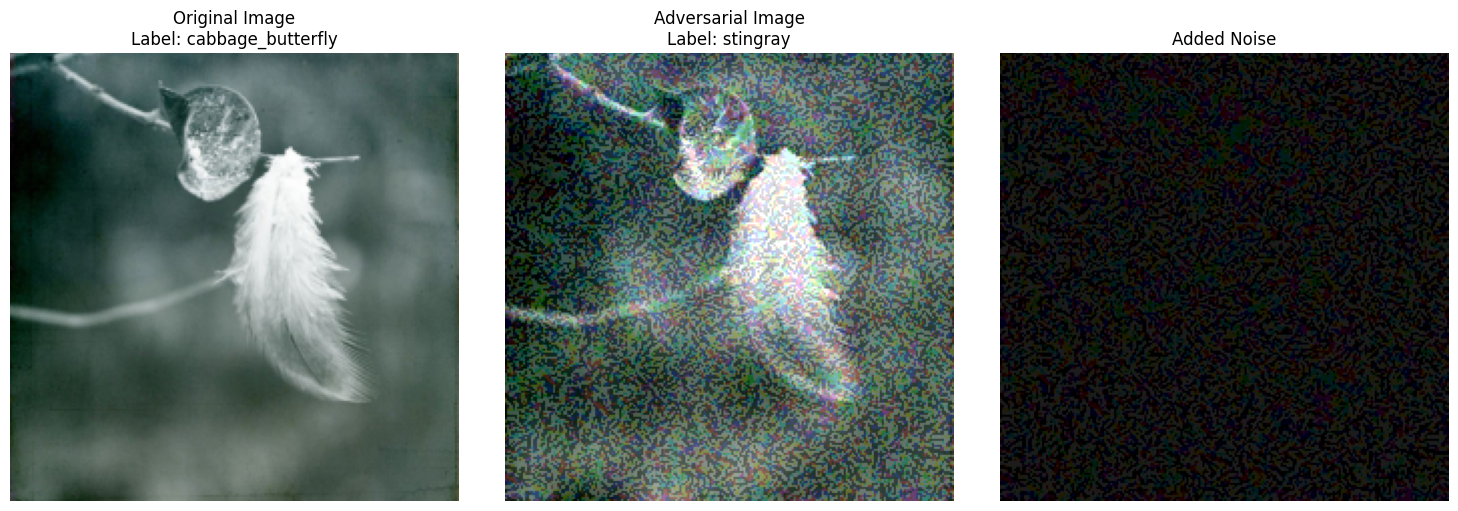

In [76]:
dir = r"/teamspace/studios/this_studio/xai-fgsm/src/data/imagenet/"
index = 118
epsilon = 0.5
image_prediction_with_attack(index, dir, epsilon)
